In [68]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

In [69]:
# Create a dictionary to store discharge cycles with info about the discharge_capacity and csv file name for certain battery
batteries_discharge_cycles = {
    'B0005': {'discharge_capacity': [], 'csv_file': []},
    'B0006': {'discharge_capacity': [], 'csv_file': []},
    'B0007': {'discharge_capacity': [], 'csv_file': []},
    'B0018': {'discharge_capacity': [], 'csv_file': []},
}

# Read and store metadata information for analyzed batteries
metadata = pd.read_csv('cleaned_dataset/metadata.csv')

# Iterate over each row in the metadata dataframe
for index, row in metadata.iterrows():
    battery_id = row['battery_id']
    data_type = row['type']
    filename = row['filename']
    discharge_capacity = row['Capacity']

    # Check if the battery ID exists in the batteries dictionary
    if battery_id in batteries_discharge_cycles:
        # Check the data type and save the file to the appropriate subdirectory
        if data_type == 'discharge':
            batteries_discharge_cycles[battery_id]['csv_file'].append(filename)
            batteries_discharge_cycles[battery_id]['discharge_capacity'].append(discharge_capacity)

for key, value in batteries_discharge_cycles.items():
    print(key, value)


B0005 {'discharge_capacity': ['1.8564874208181574', '1.846327249719927', '1.8353491942234077', '1.8352625275821128', '1.8346455082120419', '1.8356616600675495', '1.8351461429226603', '1.8257567905665537', '1.8247738529891333', '1.824613268496936', '1.8246195526864504', '1.8142019357673917', '1.8137521577549054', '1.8134404914735822', '1.8025980036306504', '1.80210690024615', '1.802579500826209', '1.8030683142834096', '1.8027776247196041', '1.8470259949329193', '1.847417311283644', '1.8361774213478947', '1.8257807475776242', '1.8251136435078368', '1.8255815042203762', '1.8140311275083907', '1.8147691941158939', '1.813969388710352', '1.802765665167823', '1.804077040117352', '1.8518025516704486', '1.8307038456739428', '1.8199041089501267', '1.8093079637028517', '1.80460990458052', '1.7993770651972192', '1.7884432335370462', '1.7829230484252723', '1.7730337158018288', '1.773037755078937', '1.7678721106662054', '1.7623150704093087', '1.7676172924938447', '1.762668359743147', '1.751730487066

In [70]:
# choose data
battery_id = 'B0005'
discharge_cycle = 1

In [71]:
DISCHARGE_PATH = f'analyzed_dataset/{battery_id}/discharge/'
# Load first file in discharge directory
df = pd.read_csv(DISCHARGE_PATH + batteries_discharge_cycles[battery_id]['csv_file'][discharge_cycle])
df.head()


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.189773,0.000021,24.697752,-0.0006,0.000,0.000
1,4.188881,-0.000879,24.685948,-0.0006,4.204,16.672
2,3.979157,-2.014654,24.738132,-1.9984,3.056,35.703
3,3.956924,-2.013703,24.897071,-1.9982,3.024,53.828
4,3.940054,-2.012797,25.084750,-1.9984,3.003,71.891


# Prior predictive checks

Below assumaptions were made for prior predictive checks:
- Rated capacity of lithium-ion battery is 2.0 Ah (according to the dataset description)
- Fully discharged voltage is 2.7 V (according to the dataset description)
- SoC is equal to 100% since the battery is fully charged
- Time and current measurements are affected by measurement errors
- Discharge capacity may differ from rated capacity since with each discharge cycle the battery capacity decreases

In [72]:
# Compile Stan model prior predictive checks
model_ppc_1 = CmdStanModel(stan_file='stan/battery_ppc_1.stan')
model_ppc_1.compile(force=True)

INFO:cmdstanpy:compiling stan file /usr/battery-pack-model-and-data/stan/battery_ppc_1.stan to exe file /usr/battery-pack-model-and-data/stan/battery_ppc_1
INFO:cmdstanpy:compiled model executable: /usr/battery-pack-model-and-data/stan/battery_ppc_1
INFO:cmdstanpy:compiling stan file /usr/battery-pack-model-and-data/stan/battery_ppc_1.stan to exe file /usr/battery-pack-model-and-data/stan/battery_ppc_1
INFO:cmdstanpy:compiled model executable: /usr/battery-pack-model-and-data/stan/battery_ppc_1


In [73]:
# Load input data from the first file
time_measured = df['Time'].values
current_measured = df['Current_measured'].values

# Find discharge mode start and end index
# Begining of the constant discharge mode is for first measured current above 0.01
first_discharge_mode_idx = np.where(np.abs(current_measured) > 0.01)[0][0]
print('First discharge mode index: ', first_discharge_mode_idx)

# End of the constant discharge mode is for last measured current above 0.01
last_discharge_mode_idx = np.where(np.abs(current_measured) > 0.01)[0][-1]
print('Last discharge mode index: ', last_discharge_mode_idx)

# Save end and begining of open circuit voltage mode
ocv_mode_end_idx = first_discharge_mode_idx - 1
ocv_mode_start_idx = last_discharge_mode_idx + 1

First discharge mode index:  2
Last discharge mode index:  178


In [79]:
# Data dictionary
data_sim_1 = {
    'N': len(time_measured),
    'time_measured': time_measured,
    'discharge_mode_start_index': first_discharge_mode_idx,
    'discharge_mode_stop_index': last_discharge_mode_idx
}

In [80]:
# Sample from prior predictive check
R = 1000
sim_1 = model_ppc_1.sample(data=data_sim_1,
                           fixed_param=True,
                           iter_sampling=R,
                           iter_warmup=0,
                           seed=1,
                           refresh=R)
                       
df_sim_1 = sim_1.draws_pd()
df_sim_1.head()


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,time[1],time[2],time[3],time[4],time[5],time[6],time[7],time[8],...,estimated_discharge[191],estimated_discharge[192],estimated_discharge[193],estimated_discharge[194],estimated_discharge[195],estimated_discharge[196],final_soc,final_discharge_capacity,prior_discharge_capacity,prior_initial_soc
0,0.0,0.0,0.0,16.4158,35.2334,54.0089,72.5542,89.8856,109.060,125.619,...,1.84039,1.84043,1.84044,1.84052,1.84064,1.84068,-0.125137,1.83956,1.64229,0.994985
1,0.0,0.0,0.0,16.2750,36.1845,54.0438,71.5414,89.6129,108.620,126.052,...,1.83927,1.83934,1.83940,1.83944,1.83950,1.83954,-0.218919,1.83861,1.51668,0.993343
2,0.0,0.0,0.0,17.0504,36.0637,53.8542,72.1812,89.9159,108.458,126.551,...,1.83833,1.83834,1.83843,1.83845,1.83857,1.83862,-0.157829,1.83794,1.59871,0.991811
3,0.0,0.0,0.0,16.9991,36.3397,53.1626,72.0792,89.8837,107.971,126.265,...,1.83926,1.83929,1.83937,1.83939,1.83952,1.83954,-0.274576,1.83859,1.44674,0.996272
4,0.0,0.0,0.0,15.6179,36.2233,53.7208,71.5191,90.5240,108.757,126.615,...,1.83886,1.83891,1.83892,1.83899,1.83901,1.83903,-0.188380,1.83828,1.55525,0.993607


In [81]:
# Extract the estimated_soc values into separate numpy arrays for each index
estimated_soc = np.zeros((R, len(time_measured)))
final_estimated_soc = np.zeros(R)
estimated_discharge = np.zeros((R, len(time_measured)))
final_estimated_discharge_capacity = np.zeros(R)
for i in range(R):
    for j in range(len(time_measured)):
        estimated_soc[i, j] = df_sim_1['estimated_soc[{}]'.format(j+1)][i] * 100
        estimated_discharge[i, j] = df_sim_1['estimated_discharge[{}]'.format(j+1)][i]
    final_estimated_soc[i] = df_sim_1['final_soc'][i] * 100
    final_estimated_discharge_capacity[i] = df_sim_1['final_discharge_capacity'][i]

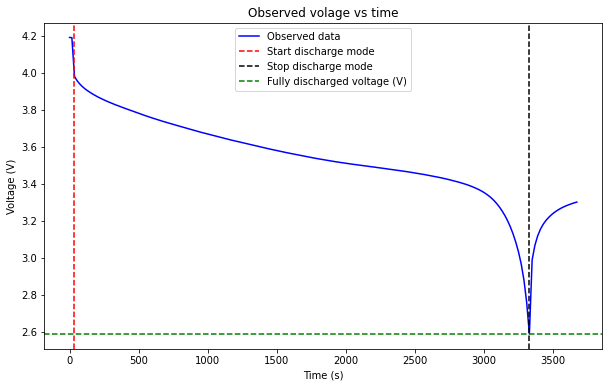

In [82]:
fully_discharged_voltage = df['Voltage_measured'].values[last_discharge_mode_idx]
# Plot on chart observed voltage vs time
# axis x shows time, axis y shows voltage
plt.figure(figsize=(10, 6))
plt.title('Observed volage vs time')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.plot(time_measured, df['Voltage_measured'].values, label='Observed data', color='blue')
# mark lines of discharge mode
plt.axvline(x=time_measured[first_discharge_mode_idx], color='red', linestyle='--', label='Start discharge mode')
plt.axvline(x=time_measured[last_discharge_mode_idx], color='black', linestyle='--', label='Stop discharge mode')
# mark line of fully discharged voltage
plt.axhline(y=fully_discharged_voltage, color='green', linestyle='--', label='Fully discharged voltage (V)')
plt.legend()
plt.show()

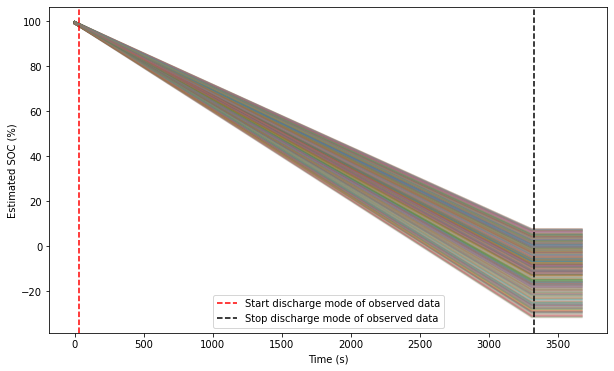

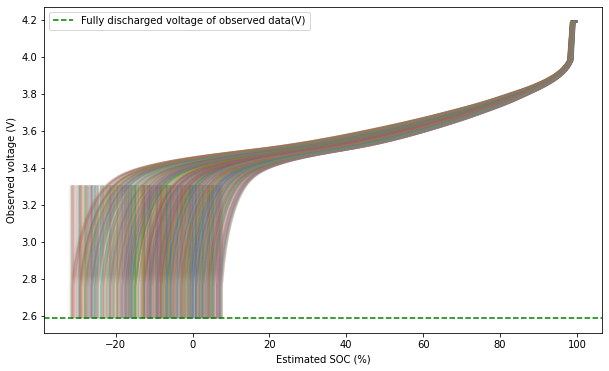

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


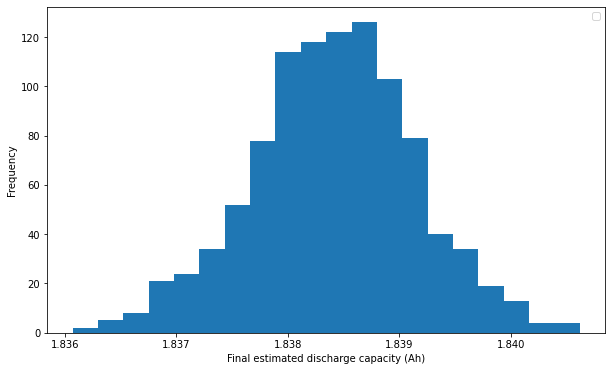

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


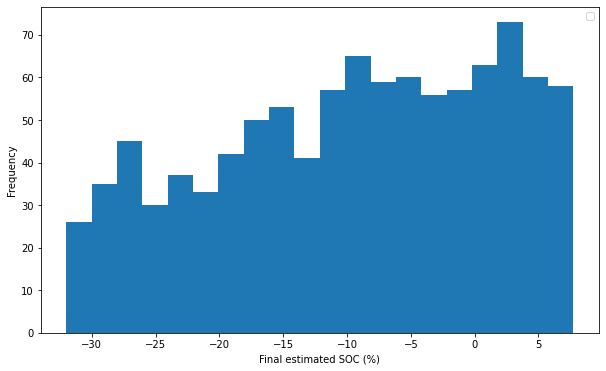

In [89]:
# Plot the estimated_soc values vs time
plt.figure(figsize=(10, 6))
for i in range(R):
    plt.plot(time_measured, estimated_soc[i, :], alpha=0.1)
# mark lines of discharge mode
plt.axvline(x=time_measured[first_discharge_mode_idx], color='red', linestyle='--', label='Start discharge mode of observed data')
plt.axvline(x=time_measured[last_discharge_mode_idx], color='black', linestyle='--', label='Stop discharge mode of observed data')
plt.xlabel('Time (s)')
plt.ylabel('Estimated SOC (%)')
plt.legend()
plt.show()

# Plot the estiamted_soc values vs observed voltage
plt.figure(figsize=(10, 6))
for i in range(R):
    plt.plot(estimated_soc[i, :], df['Voltage_measured'].values, alpha=0.1)
# mark line of fully discharged voltage
plt.axhline(y=fully_discharged_voltage, color='green', linestyle='--', label='Fully discharged voltage of observed data(V)')
plt.xlabel('Estimated SOC (%)')
plt.ylabel('Observed voltage (V)')
plt.legend()
plt.show()

# Plot the histogram of the final estimated_discharge_capacity values
plt.figure(figsize=(10, 6))
plt.hist(final_estimated_discharge_capacity, bins=20)
# # mark observed discharge capacity
# plt.axvline(x = batteries_discharge_cycles[battery_id]['discharge_capacity'][discharge_cycle], color='red', linestyle='--', label='Observed discharge capacity (Ah)')
plt.xlabel('Final estimated discharge capacity (Ah)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the histogram of the final estimated soc values
plt.figure(figsize=(10, 6))
plt.hist(final_estimated_soc, bins=20)
plt.xlabel('Final estimated SOC (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
